## Курсовой проект
**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной **(0 или 1, а НЕ вероятность)** для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатываться от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном файле (ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

In [275]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from collections import Counter

In [229]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

### Загрузка данных

In [100]:
df_train = pd.read_csv('project_predict_credit/course_project_train.csv')
df_test = pd.read_csv('project_predict_credit/course_project_test.csv')
print('Data is loaded!')

Data is loaded!


In [84]:
print(f"Train:\t{df_train.shape[0]} objects and {df_train.shape[1]} features")
print(f'Test:\t{df_test.shape[0]} objects and {df_test.shape[1]} features')

Train:	7500 objects and 17 features
Test:	2500 objects and 16 features


In [85]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [86]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


### Описание данных

1.**Home Ownership** - домовладение

2.**Annual Income** - годовой доход

3.**Years in current job** - количество лет на текущем месте работы

4.**Tax Liens** - налоговые льготы

5.**Number of Open Accounts** - количество открытых счетов

6.**Years of Credit History** - количество лет кредитной истории

7.**Maximum Open Credit** - наибольший открытый кредит

8.**Number of Credit Problems** - количество проблем с кредитом

9.**Months since last delinquent** - количество месяцев с последней просрочки платежа

10.**Bankruptcies** - банкротства

11.**Purpose** - цель кредита

12.**Term** - срок кредита

13.**Current Loan Amount** - текущая сумма кредита

14.**Current Credit Balance** - текущий кредитный баланс

15.**Monthly Debt** - ежемесячный долг

16.**Credit Score** - кредитный рейтинг

17.**Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [87]:
df_train.dtypes #Типы полей признаков

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [68]:
TARGET = 'Credit Default'
numeric_features = df_train.select_dtypes('number').columns.drop(TARGET)
categorical_features = df_train.select_dtypes('object').columns

### Преобразование данных

In [88]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обработка пропусков и выбросов

In [90]:
df_train.isnull().sum() #Исследуем пропуски

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [91]:
# Функция по подсчету пропусков в колонках
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [92]:
missing_values_table(df_train)

Your selected dataframe has 17 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


In [93]:
missing_values_table(df_test)

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,1358,54.3
Annual Income,513,20.5
Credit Score,513,20.5
Years in current job,86,3.4
Bankruptcies,3,0.1


У признака Months since last delinquent пропущно более половины значений, что скорее всего будет плохо влиять на модель. (Удаляем колонку).
Поскольку это количество месяцев с последней просрочки платежа, можно предположить, что просто просрочки не было у этих объектов. (Заменяем знаечние на ноль или на очень большое число 999999, просрочка была очень давно).

Проверим корреляцию признаков с целевой переменной

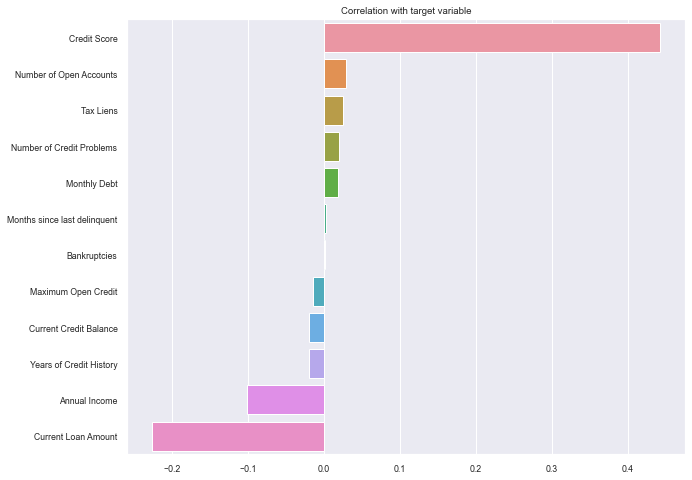

In [94]:
corr_with_target = df_train[df_train.columns.drop('Credit Default').tolist() + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable');

Так как корреляции нет, то мы можем удалить признак Months since last delinquent.

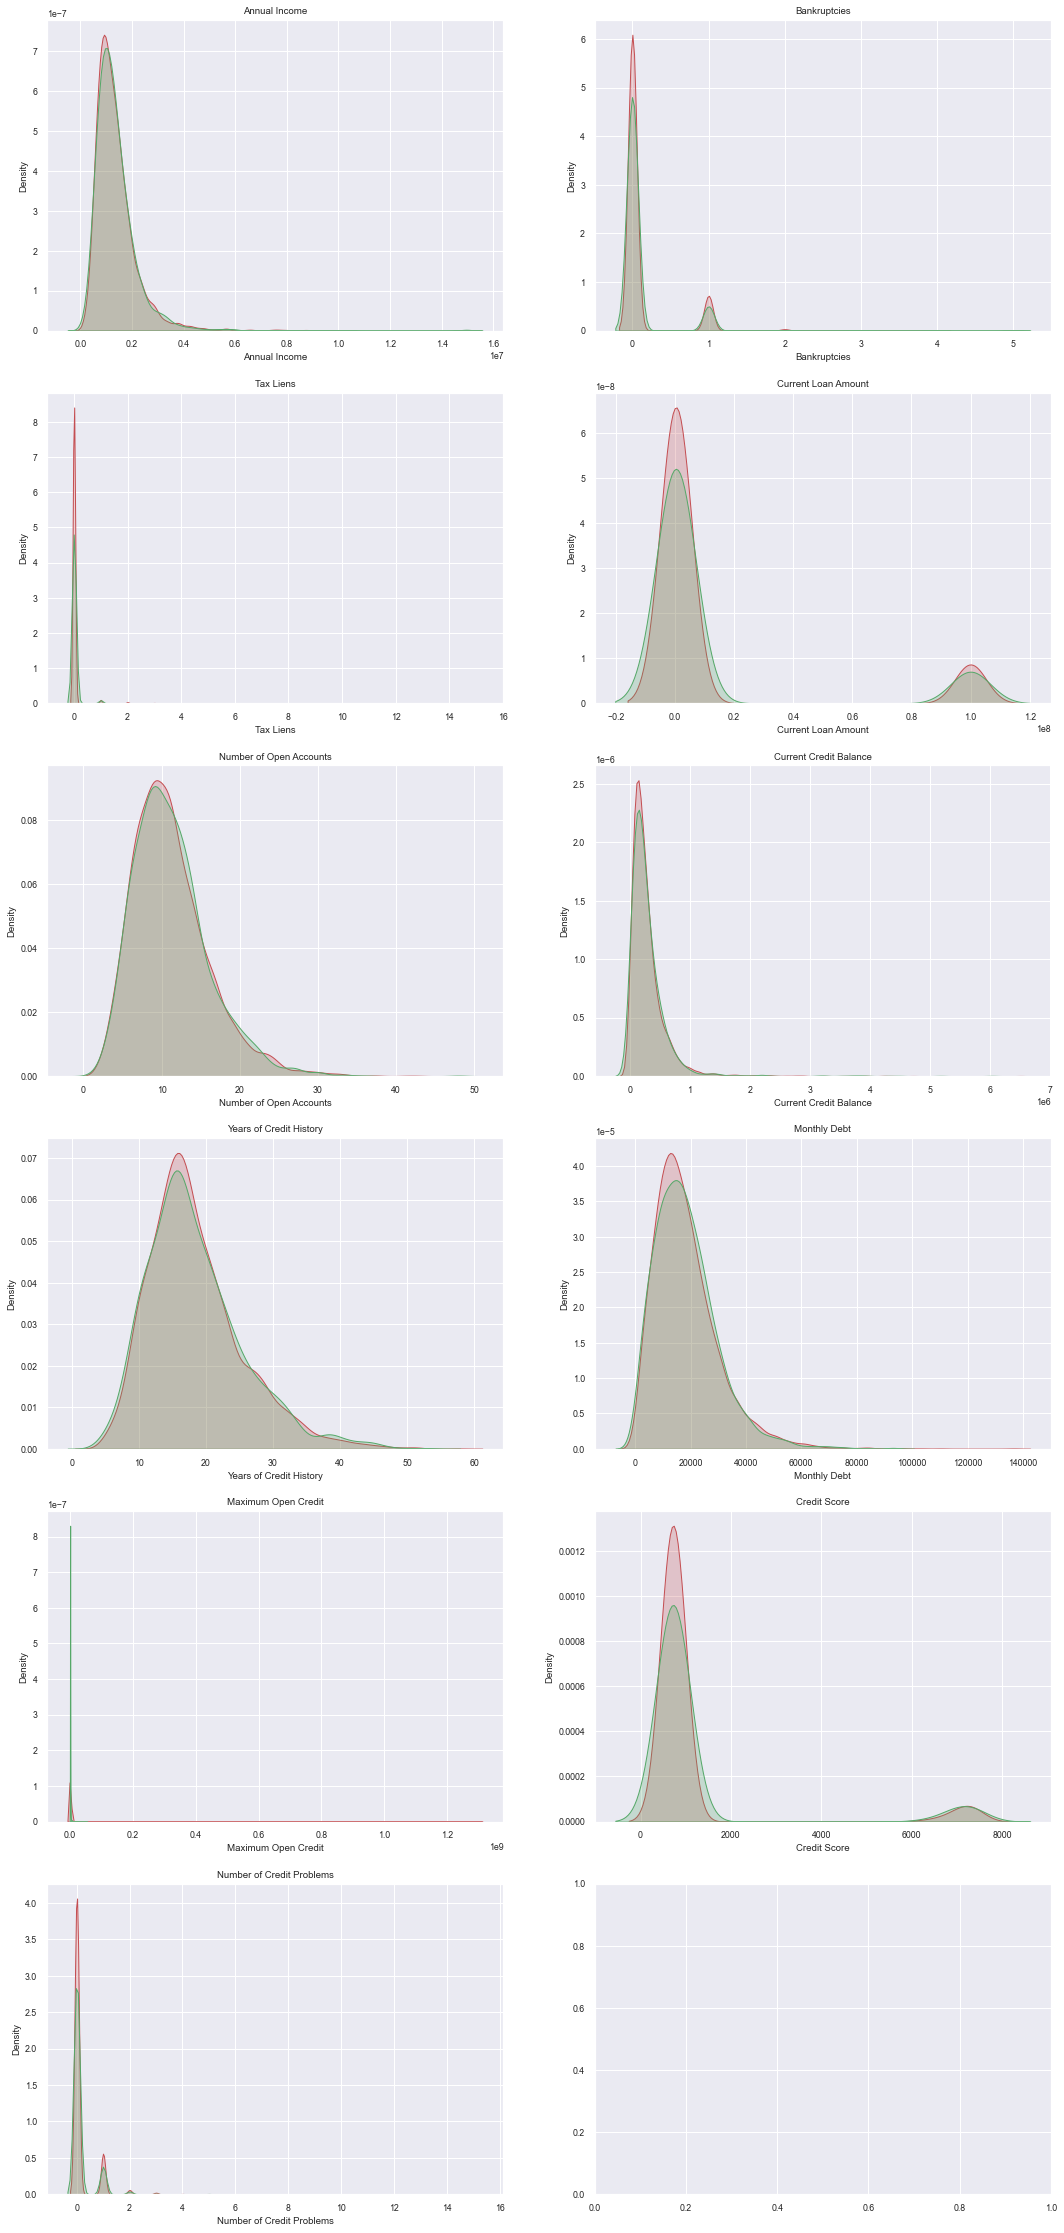

In [95]:
# Проверим распределения остальных количественных признаков.
N_ROWS, N_COLS = 6, 2

fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(18, 40, forward=True)

for i, col in enumerate(numeric_features):
    sns.set(font_scale=0.8)
    sns.kdeplot((df_train[col]), shade=True, label='train', color='r', ax=ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)])
    sns.kdeplot((df_test[col]), shade=True, label='test', color='g', ax=ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)])
    ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)].set_title(col)
    
plt.show()

Так как распределения некотрых признаков в test и train не соответствуют, то удалим эти признаки: 'Tax Liens','Maximum Open Credit', 'Bankruptcies' , 'Years in current job'. Между целевой и признаками 'Bankruptcies', 'Maximum open credit' также отмечается и маленькая корреляция. Удалим их. 

In [96]:
# Обработка выбросов в Кредитном рейтинге. 
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score']

69      6470.0
87      7440.0
94      7010.0
96      7320.0
116     7390.0
         ...  
7422    6690.0
7433    6060.0
7450    7290.0
7460    7470.0
7496    7410.0
Name: Credit Score, Length: 400, dtype: float64

Замена пропусков в Credit Score и изменение выбросов больше тысячи, так как кредитный рейтинг по данным российскихх банков может быть от 1 до 1000.



В датасете присутствуют наблюдения с выбросами "Current Loan Amount", которые равны 99999999. Приравняем их к модулю разности "Maximum Open Credit" и "Current Credit Balance". Таким образом мы допускаем, что текущий кредит является наибольшим и текущая сумма кредита равна разности максимального кредита и текущего баланса кредита.

In [99]:
def clear_def(df_in): 
    
    df = df_in.copy()
    
    # Замена значений в кредитном рейтинге.
    df.loc[df['Credit Score'] > 1000, 'Credit Score'] = \
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] // 10
    
    # Замена значений в текущей сумме кредита.
    df.loc[(df['Current Loan Amount']==99999999), 'Current Loan Amount'] = \
        np.absolute(df.loc[(df_train['Current Loan Amount']==99999999), 'Maximum Open Credit'] - \
        df.loc[(df['Current Loan Amount']==99999999), 'Current Credit Balance'])
    
    #Удаление признаков.
    df = df.drop(['Months since last delinquent'],axis=1)
    df = df.drop(['Bankruptcies'], axis=1)
    df = df.drop(['Maximum Open Credit'], axis=1)
    return df

In [122]:
df_train_clear = clear_def(df_train)
df_test_clear = clear_def(df_test)

#### Категориальные переменные

In [104]:
for cat_colname in df_train.select_dtypes(include=['object']).columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
**************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
************************

In [109]:
# Функция для перевода признака 'Years in current job' в числовой.
def cur_job(df):
    
    # Удаляем текстовые данные из весх колонок, оставляем только численные значения
    df['Years in current job'] = df['Years in current job'].replace(regex = True, to_replace = r'\W\s\D+$|\s\D+$', value = '').replace('< 1', 0)
    
    # Заполняем пропуски медианой.
    df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].median()
    
    # Изменяем тип на числовой.
    df['Years in current job'] = df['Years in current job'].astype('int')
    return df

In [123]:
df_train_clear = cur_job(df_train_clear)
df_test_clear = cur_job(df_test_clear)
df_train_clear.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Number of Credit Problems,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,6,0.0,11.0,26.3,1.0,debt consolidation,Short Term,638574.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,0.0,debt consolidation,Short Term,874045.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,1.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Annual Income и Credit Score пропущено одинаковое количество, и строки пропусков совпадают. Проверим корреляцию всех признаков. 

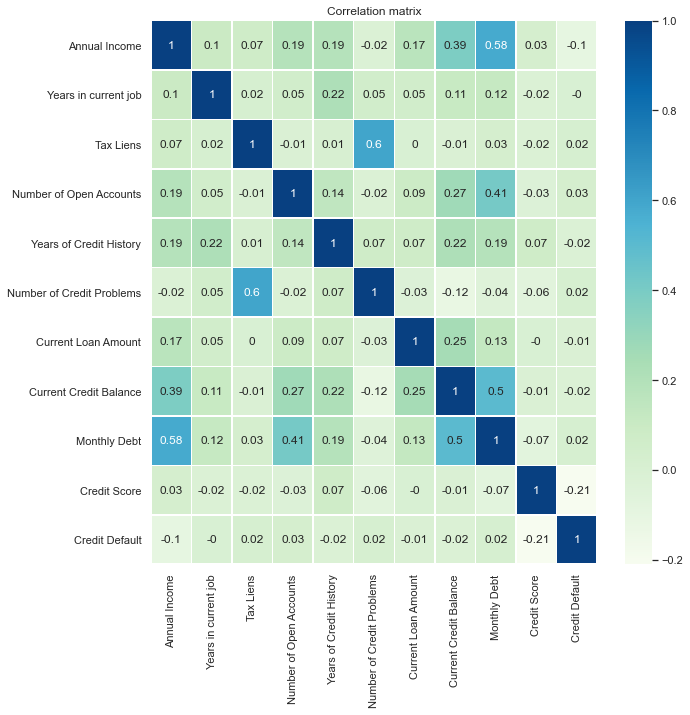

In [184]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1)
sns.heatmap(df_train_clear.corr().round(2), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix');

Корреляция Annual Income, Credit Score слабая с другими признаками. Преобразуем пропущенные значения с помощью Iterative Imputer. 

In [181]:
num_features = df_train_clear.select_dtypes('number').columns.drop(TARGET)
cat_features = df_train_clear.select_dtypes('object').columns

num_train = df_train_clear[num_features]
num_test = df_test_clear[num_features]

cat_train = df_train_clear[cat_features]
cat_test = df_test_clear[cat_features]

In [177]:
imputer = IterativeImputer(max_iter = 100)
imput_train = pd.DataFrame(imputer.fit_transform(df_train_clear[num_features]))
imput_test = pd.DataFrame(imputer.transform(df_test_clear[num_features]))

In [179]:
imput_train.columns = num_train.columns 
imput_test.columns = num_test.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              2500 non-null   float64
 1   Years in current job       2500 non-null   float64
 2   Tax Liens                  2500 non-null   float64
 3   Number of Open Accounts    2500 non-null   float64
 4   Years of Credit History    2500 non-null   float64
 5   Number of Credit Problems  2500 non-null   float64
 6   Current Loan Amount        2500 non-null   float64
 7   Current Credit Balance     2500 non-null   float64
 8   Monthly Debt               2500 non-null   float64
 9   Credit Score               2500 non-null   float64
dtypes: float64(10)
memory usage: 195.4 KB


In [197]:
df_train_full = pd.concat([cat_train, imput_train], axis = 1)
df_train_full = pd.concat([df_train_full, df_train[TARGET]], axis = 1)

df_test_full = pd.concat([cat_test, imput_test], axis = 1)

In [198]:
# Преобразуем колонки 'Home Ownership', 'Term', 'Purpose' в дамми переменные.
df_train_dum = pd.get_dummies(df_train_full, columns=['Home Ownership', 'Term', 'Purpose'])
df_test_dum = pd.get_dummies(df_test_full, columns=['Home Ownership', 'Term', 'Purpose'])

In [202]:
#df_train_dum = df_train_dum.drop(['Purpose_renewable energy'], axis=1) # цель кредита, которой нет в тестовом датасете.
df_train_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Years in current job          7500 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Number of Credit Problems     7500 non-null   float64
 6   Current Loan Amount           7500 non-null   float64
 7   Current Credit Balance        7500 non-null   float64
 8   Monthly Debt                  7500 non-null   float64
 9   Credit Score                  7500 non-null   float64
 10  Credit Default                7500 non-null   int64  
 11  Home Ownership_Have Mortgage  7500 non-null   uint8  
 12  Home Ownership_Home Mortgage  7500 non-null   uint8  
 13  Hom

In [203]:
df_test_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   float64
 2   Tax Liens                     2500 non-null   float64
 3   Number of Open Accounts       2500 non-null   float64
 4   Years of Credit History       2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Current Loan Amount           2500 non-null   float64
 7   Current Credit Balance        2500 non-null   float64
 8   Monthly Debt                  2500 non-null   float64
 9   Credit Score                  2500 non-null   float64
 10  Home Ownership_Have Mortgage  2500 non-null   uint8  
 11  Home Ownership_Home Mortgage  2500 non-null   uint8  
 12  Home Ownership_Own Home       2500 non-null   uint8  
 13  Hom

### Балансировка данных

In [232]:
def balance_df_over_under_sampling_binary(df, target_name):
     
    major_class, minor_class = df[target_name].value_counts().index
    
    major_quantity = df[target_name].value_counts()[major_class]
    minor_quantity = df[target_name].value_counts()[minor_class]
    
    coef_major, coef_minor = 1, 1
    
    while (minor_quantity * coef_minor) / (major_quantity * coef_major) < 0.9:
        
        coef_major -= 0.05
        coef_minor += 0.05
        
    df_major = df[df[target_name] == major_class].sample(frac=round(coef_major, 2), replace=True)
    df_minor = df[df[target_name] == minor_class].sample(frac=round(coef_minor, 2), replace=True)
    
    return pd.concat([df_major, df_minor], axis=0, ignore_index=True)

In [234]:
df_train_dum['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [235]:
df_train_overfull = balance_df_over_under_sampling_binary(df_train_dum, 'Credit Default')

In [236]:
df_train_overfull['Credit Default'].value_counts()

0    3232
1    2958
Name: Credit Default, dtype: int64

### Построение и оценка моделей

In [238]:
X = df_train_overfull.drop(TARGET, axis=1)
y = df_train_overfull[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4642, 30), (1548, 30), (4642,), (1548,))

In [240]:
scaler_credit = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler_credit.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler_credit.transform(X_val), columns=X_val.columns)

In [241]:
# Список индексов категориальных признаков
cat_features_lst = []

cat_columns = X.select_dtypes(include='uint8').columns

for idx, column in enumerate(X.columns):
    if column in cat_columns:
        cat_features_lst.append(idx)
        
X_train_scaled[cat_columns] = X_train_scaled[cat_columns].astype('int32', copy=False)
X_val_scaled[cat_columns] = X_val_scaled[cat_columns].astype('int32', copy=False)

In [242]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Логистическая регрессия

In [243]:
model_lr = LogisticRegression(random_state = 21, n_jobs=-1)
model_lr.fit(X_train_scaled, y_train)

y_train_pred = model_lr.predict(X_train_scaled)
y_val_pred = model_lr.predict(X_val_scaled)

get_classification_report(y_train, y_train_pred, y_val, y_val_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.63      0.74      0.68      2407
           1       0.65      0.53      0.58      2235

    accuracy                           0.64      4642
   macro avg       0.64      0.63      0.63      4642
weighted avg       0.64      0.64      0.63      4642

TEST

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       825
           1       0.64      0.55      0.60       723

    accuracy                           0.65      1548
   macro avg       0.65      0.64      0.64      1548
weighted avg       0.65      0.65      0.64      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               602  223
1               322  401


### XGBoost

In [266]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21, nthread=-1, use_label_encoder=False)
model_xgb.fit(X_train_scaled, y_train, eval_metric = 'error')

y_train_pred = model_xgb.predict(X_train_scaled)
y_val_pred = model_xgb.predict(X_val_scaled)

get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2407
           1       0.99      0.98      0.98      2235

    accuracy                           0.99      4642
   macro avg       0.99      0.99      0.99      4642
weighted avg       0.99      0.99      0.99      4642

TEST

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       825
           1       0.80      0.82      0.81       723

    accuracy                           0.82      1548
   macro avg       0.82      0.82      0.82      1548
weighted avg       0.82      0.82      0.82      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               675  150
1               132  591
Wall time: 756 ms


### LightGBM

In [248]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train_scaled, y_train, categorical_feature=cat_features_lst)

y_train_pred = model_lgbm.predict(X_train_scaled)
y_test_pred = model_lgbm.predict(X_val_scaled)

get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

c:\users\chern\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2407
           1       0.93      0.92      0.92      2235

    accuracy                           0.93      4642
   macro avg       0.93      0.93      0.93      4642
weighted avg       0.93      0.93      0.93      4642

TEST

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       825
           1       0.80      0.82      0.81       723

    accuracy                           0.82      1548
   macro avg       0.82      0.82      0.82      1548
weighted avg       0.82      0.82      0.82      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               675  150
1               132  591
Wall time: 376 ms


### CatBoost

In [250]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

model_catb.fit(catb.Pool(X_train_scaled, y_train, cat_features=cat_columns))

y_train_pred = model_catb.predict(catb.Pool(X_train_scaled, cat_features=cat_columns))
y_test_pred = model_catb.predict(catb.Pool(X_val_scaled, cat_features=cat_columns))

get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2407
           1       0.90      0.87      0.88      2235

    accuracy                           0.89      4642
   macro avg       0.89      0.89      0.89      4642
weighted avg       0.89      0.89      0.89      4642

TEST

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       825
           1       0.80      0.82      0.81       723

    accuracy                           0.82      1548
   macro avg       0.82      0.82      0.82      1548
weighted avg       0.82      0.82      0.82      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               675  150
1               132  591
Wall time: 5.65 s


#### Бустинговые модели показали лучший результат по метрикам. Модели LightGBM и XGBoost показали примерно одинаковый результат по скорости.

### Построение финальной модели

In [251]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [256]:
y_val_pred_probs = model_xgb.predict_proba(X_val_scaled)

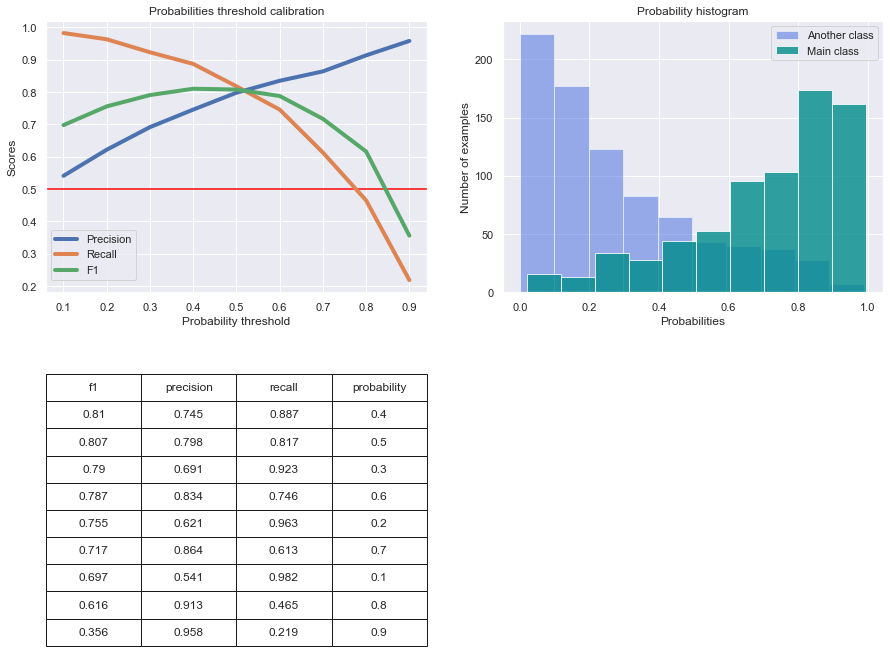

In [257]:
show_proba_calibration_plots(y_val_pred_probs[:, 1], y_val)

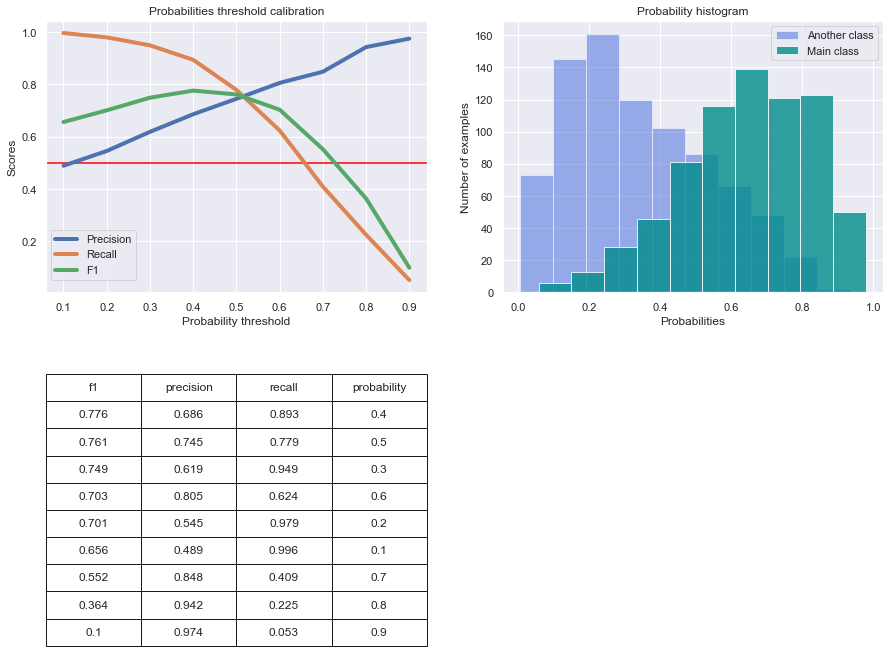

In [258]:
y_val_pred_probs = model_lgbm.predict_proba(X_val_scaled)
show_proba_calibration_plots(y_val_pred_probs[:, 1], y_val)

##### XGBoost - лучшие параметры.

### Финальная модель.

In [267]:
scaler_final = MinMaxScaler()
X_scale = pd.DataFrame(scaler_final.fit_transform(X), columns=X.columns)

model_final = xgb.XGBClassifier(random_state=21, nthread=-1,  use_label_encoder=False)

model_final.fit(X_scale, y, eval_metric = "error")


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Прогноз

In [269]:
Test_scale = pd.DataFrame(scaler_final.transform(df_test_dum), columns=df_test_dum.columns)

Test_y_pred = model_final.predict(Test_scale)

Test_y_pred_proba = model_final.predict_proba(Test_scale)

In [272]:
Test_y_pred

array([1, 0, 0, ..., 1, 0, 1])

#### Изменение порога, колибровка классов

In [291]:
Test_y_final = Test_y_pred.copy()
Test_y_final[np.where(Test_y_pred_proba[:,1] < 0.51)] = 0

In [292]:
print(f'До калибровки: {Counter(Test_y_pred)}')
print(f'После калибровки: {Counter(Test_y_final)}')

До калибровки: Counter({0: 1583, 1: 917})
После калибровки: Counter({0: 1608, 1: 892})


##### Запись в файл

In [293]:
pred_credit = pd.DataFrame(Test_y_final)
pred_credit.to_csv('AChernova_predictions.csv', index=False, header=False, encoding='utf-8')